In [65]:
import pytc
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import seaborn as sns
import glob
import pandas as pd

%matplotlib inline

In [181]:
class Sliders():
    def __init__(self, exp, fitter, gui, param_name):
        """
        """
        self._var_opt = {'link': ['blank'], 'unlink': ['unlink']}
        
        self._loc_link = widgets.Dropdown(value = self._var_opt['unlink'], options = self._var_opt)
        self._glob_link = widgets.Dropdown(value = self._loc_link.value[0], options = self._loc_link.value)
        self._fixed_check = widgets.Checkbox(description = 'Fix? ', value = False)
        self._slider = widgets.FloatSlider(description = 'Guess ')
        self._fixed_int = widgets.BoundedFloatText(description = 'F', display = 'none')
        self._s_min = widgets.FloatText(description = '∧')
        self._s_max = widgets.FloatText(description = '∨')
        self._all_widgets = widgets.VBox()
        
        self._exp = exp
        self._fitter = fitter
        self._gui = gui
        self._param_name = param_name
        
        self._fixed_check.layout.width = '80px'
        self._loc_link.layout.width = '200px'
        self._glob_link.layout.width = '200px'
        self._slider.layout.width = '300px'
        self._s_min.layout.width = '110px'
        self._s_max.layout.width = '110px'
        self._fixed_int.layout.width = '120px'
        self._fixed_int.layout.display = 'none'
    
    def logic(self):
        """
        handle trait changes for each widget and link to the fitter.
        """
    
        self._fixed_check.observe(self.check_change, 'value')
        self._loc_link.observe(self.link_change, 'value')
        self._s_min.observe(self.min_change, 'value')
        self._s_max.observe(self.max_change, 'value')
        self._slider.observe(self.param_change, 'value')
        
    def update_fit(self, fixed, guess, bounds_min, bounds_max, fixed_int):
        """
        """
        global_param, local_param = self._fitter.fit_param
        global_error, local_error = self._fitter.fit_error
        
        local_var = {}
        global_var = {}
        
        guess = self._exp.model.param_guesses[self._param_name]

        n=0
        for param, error in zip(local_param, local_error):
            for p, e in zip(param, error):
                local_var["{},{}".format(p, n)] = {'param': param[p], 'error': error[e]}
                #print("{},{}".format(p, n), ': ', param[p], error[e])
            n+=1

        for param, error in zip(global_param.keys(), global_error.keys()):
            global_var[param] = {'param': global_param[param], 'error': global_error[error]}
            #print(param, ': ', global_param[param], global_error[error])
            
        df1 = pd.DataFrame.from_dict(local_var, 'index')
        df2 = pd.DataFrame.from_dict(global_var, 'index')
        
        df1.append(df2)
        
        display(df1)
            
        self._fitter.fit()
        self._fitter.plot()
        
    def close_sliders(self):
        """
        """
        self._all_widgets.close()

    def min_change(self, min_val):
        """
        change minimum for fixed integer and slider widgets, update bounds and range for parameter.
        """
        self._slider.min = min_val['new']
        #self._fixed_int.min = min_val['new']
        self.update_bounds(self._slider.min, self._slider.max)

    def max_change(self, max_val):
        """
        change maximum for fixed integer and slider widgets, update bounds and range for parameter.
        """
        self._slider.max = max_val['new']
        #self._fixed_int.max = max_val['new']
        self.update_bounds(self._slider.min, self._slider.max)
        
    def update_bounds(self, s_min, s_max):
        """
        """
        pass

    def check_change(self, val):
        """
        update if parameter is fixed and change widget view
        """
        if val['new']:
            self._slider.layout.display = 'none'
            self._fixed_int.layout.display = ''
            self._fitter.fix(self._exp, **{self._param_name: self._fixed_int.value})
        elif val['new'] == False and self._loc_link.value == ['link']:
            self._slider.layout.display = 'none'
            self._fixed_int.layout.display = 'none'
            self._min_max.layout.display = 'none'
            self._bounds.layout.display = 'none'
            self._fitter.unfix(*[self._param_name], expt = self._exp)
        elif val['new'] == False and self._loc_link.value == ['unlink']: 
            self._slider.layout.display = ''
            self._fixed_int.layout.display = 'none'
            self._min_max.layout.display = ''
            self._bounds.layout.display = ''
            self._fitter.unfix(*[self._param_name], expt = self._exp)

        #fixed and update fixed

    def link_change(self, select):
        """
        update if parameter is linked or unlinked from a global parameter and update widget view
        """
        if select['new'] == ['unlink'] and self._fixed_check.value == False:
            self._slider.layout.display = ''
            self._fixed_int.layout.display = 'none'
            self._s_min.layout.display = ''
            self._s_max.layout.display = ''
            self._fixed_check.layout.display = ''
        elif select['new'] == ['unlink'] and self._fixed_check.value:
            self._slider.layout.display = 'none'
            self._fixed_int.layout.display = ''
            self._s_min.layout.display = ''
            self._s_max.layout.display = ''
            self._fixed_check.layout.display = ''
        else:
            self._slider.layout.display = 'none'
            self._fixed_int.layout.display = 'none'
            self._s_min.layout.display = 'none'
            self._s_max.layout.display = 'none'
            self._fixed_check.layout.display = 'none'
                
    def param_change(self, param_val):
        """
        update parameter value guess based on slider value
        """
        guess = param_val['new']
        
        self._fitter.update_guess(self._param_name, guess, self._exp)
    
    def build_sliders(self):
        """
        build sliders!
        """
        pass
        
class LocalSliders(Sliders):
    def __init__(self, exp, fitter, gui, param_name, global_vars, global_exp):
        super().__init__(exp, fitter, gui, param_name)
        
        self._global_vars = global_vars
        self._global_exp = global_exp
        
    def update_bounds(self, s_min, s_max):
        """
        update bound and range for the parameter
        """
        bounds = [s_min, s_max]
        self._fitter.update_bounds(self._param_name, bounds, self._exp)
        
        # check if bounds are smaller than range, then update.
        curr_range = self._exp.model.param_guess_ranges[self._param_name]
        curr_bounds = self._exp.model.bounds[self._param_name]
        
        if curr_range[0] < curr_bounds[0] or curr_range[1] > curr_bounds[1]:
            self._fitter.update_range(self._param_name, bounds, self._exp)
            
    def create_global(self, g):
        """
        link local parameter to global parameter, create new global experiment object, and generate new sliders.
        """
        if g != 'unlink' and g != 'blank':
            try:
                self._fitter.link_to_global(self._exp, self._param_name, g)
                if g not in self._global_exp:
                    new_global = GlobalExp(self._gui, self._global_exp, self._fitter, g)
                    self._global_exp[g] = new_global
                    new_global.gen_exp()
            except:
                pass
            
            self._fitter.fit()
            self._fitter.plot()
            

    def create_local(self, l):
        """
        update list of global variables and choose to link or unlink local parameter
        """

        self._var_opt['link'] = self._global_vars
        self._loc_link.options = self._var_opt
        
        if l[0] == 'unlink':
            try:
                self._fitter.unlink_from_global(self._exp, self._param_name)
            except: 
                pass
        else:
             self._glob_link.options = l
        
                
    def build_sliders(self):
        """
        """
        self.logic()
        
        exp_range = self._exp.model.param_guess_ranges[self._param_name]
        self._slider.min = exp_range[0]
        self._slider.max = exp_range[1]
        self._slider.value = self._exp.model.param_guesses[self._param_name]
        
        #self._fixed_int = exp_range[0]
        #self._fixed_int = exp_range[1]
        
        loc_inter = widgets.interactive(self.create_local, l = self._loc_link)
        glob_inter = widgets.interactive(self.create_global, g =  self._glob_link)
        
        main_interactive = widgets.interactive(self.update_fit,
                                               fixed = self._fixed_check,
                                               guess = self._slider,
                                               bounds_min = self._s_min,
                                               bounds_max = self._s_max,
                                               fixed_int = self._fixed_int,)
        
        children = main_interactive.children + (loc_inter, glob_inter)
        main = widgets.HBox(children = children)
        
        name_label = widgets.Label(value = "{}: ".format(self._param_name))
        
        self._all_widgets.children = [name_label, main]
        #self._all_widgets.layout.width = '90%'
        self._all_widgets.layout.margin = '0px 0px 20px 0px'

        display(self._all_widgets)
        
class GlobalSliders(Sliders):
    def __init__(self, exp, fitter, gui, param_name):
        super().__init__(exp, fitter, gui, param_name)
        
    def update_bounds(self, s_min, s_max):
        """
        update bound and range for global parameter
        """
        bounds = [s_min, s_max]
        self._fitter.update_bounds(self._param_name, bounds, self._exp)
        
        # check if bounds are smaller than range, then update.
        curr_range = self._fitter.param_ranges[0][self._param_name]
        curr_bounds = self._fitter.param_bounds[0][self._param_name]
        
        if curr_range[0] < curr_bounds[0] or curr_range[1] > curr_bounds[1]:
            self._fitter.update_range(self._param_name, bounds, self._exp)
               
    def build_sliders(self):
        """
        """
        self.logic()

        exp_range = self._fitter.param_ranges[0][self._param_name]
        self._slider.min = exp_range[0]
        self._slider.max = exp_range[1]
        self._slider.value = self._fitter.param_guesses[0][self._param_name]
        
        #self._fixed_int = exp_range[0]
        #self._fixed_int = exp_range[1]
        
        name_label = widgets.Label(value = "{}: ".format(self._param_name))
        
        main_interactive = widgets.interactive(self.update_fit,
                                               fixed = self._fixed_check,
                                               guess = self._slider,
                                               bounds_min = self._s_min,
                                               bounds_max = self._s_max,
                                               fixed_int = self._fixed_int,)
        
        main = widgets.HBox(children = main_interactive.children)
        
        self._all_widgets.children = [main]
        #self._all_widgets.layout.width = '90%'
        self._all_widgets.layout.margin = '0px 0px 20px 0px'

        display(self._all_widgets)

In [193]:
class ParamCollect():
    def __init__(self, gui, container, fitter):
        """
        """
        self._gui = gui
        self._exp_id = ''
        self._exp_val = ''
        self._widgets = []
        self._fitter = fitter
        self._container = container
        self._parameters = {}
        self._models = {"blank" : pytc.models.Blank,
          "single site" : pytc.models.SingleSite,  
          "single site competitor" : pytc.models.SingleSiteCompetitor, 
          "binding polynomial" : pytc.models.BindingPolynomial}
        self._current_model = ''
        
        self._exp_box = widgets.HBox()
        
        self._sliders = []
        
    def remove_button(self, b):
        """
        remove exp from fitter and lists
        """
        pass
    
    def parameters(self):
        """
        get parameters for experiment
        """
        pass
        
    def create_exp(self):
        """
        create a new pytc experiment
        """
        pass
        
    @property        
    def exp_id(self):
        """
        return experiment id
        """
        
        return self._exp_id
    
    
    def gen_sliders(self):
        """
        generate sliders for each experiment, give option to link to global.
        """
        
        pass
    
    def gen_exp(self):
        """
        generate widgets for experiment.
        """
        pass
    
class LocalExp(ParamCollect):
    """
    create experiment object and generate widgets
    """
    def __init__(self, gui, container, fitter, global_vars, global_exp):
        super().__init__(gui, container, fitter)

        self._global_vars = global_vars
        self._global_exp = global_exp
        
        self._exp_field = widgets.Text(description = "exp: ")
        self._model_drop = widgets.Dropdown(options = self._models, value = self._models["blank"])
        self._rm_exp = widgets.Button(description = "remove experiment")
        
    def remove_button(self, b):
        """
        remove experiment from analysis and close widgets. for use with button widget.
        """
        try:
            self._gui.remove_experiment(self._exp_id)
        except:
            clear_output()
            print("no experiment linked")
            
        for i in self._container:
            if self._exp_id == i._exp_id:
                self._container.remove(i)
        
        self._exp_box.close()
                
        if self._sliders:
            for s in self._sliders:
                s.close_sliders()
                
    def remove_exp(self):
        """
        remove experiment and sliders, for use without button widget.
        """
        self.remove_button(None)
        
    def create_exp(self):
        """
        create new pytc exp
        """
        
        self._exp_val = self._exp_field.value
        if self._exp_val != 'none':
            self._current_model = self._model_drop.value
            self._exp_id = pytc.ITCExperiment(self._exp_val, self._current_model)
        else:
            clear_output()
            print("no exp data given")
    
    @property
    def parameters(self):
        """
        generate local parameters for experiment.
        """
        
        param = self._exp_id.model.param_values
        
        return param
    
    def gen_sliders(self):
        """
        generate sliders for each experiment, give option to link to global.
        """
        parameters = self.exp_id.param_values
        
        for p in parameters.keys():
            s = LocalSliders(self._exp_id, self._fitter, self._gui, p, self._global_vars, self._global_exp)
            self._sliders.append(s)
            
     
    def add_exp(self, sender):
        """
        generate sliders for experiment based on added data.
        """
        #self._exp_val = sender['new']
        self.create_exp()
        
        self._gui.add_experiment(self._exp_id)
        self.gen_sliders()
        
        self._exp_field.disabled = True
        self._model_drop.disabled = True
        
        for s in self._sliders:
            s.build_sliders()
            
    
    def gen_exp(self):
        """
        generate widgets for experiment.
        """
        
        self._exp_field.on_submit(self.add_exp)
        
        file_list = glob.glob("./**/*.DH")
        file_dict = {fname.split('/')[-1]: fname for fname in file_list}
        
        #exp_drop = widgets.Dropdown(options = file_dict, value = 'none')
        #exp_drop.observe(add_exp, 'value')

        self._rm_exp.on_click(self.remove_button)

        self._exp_box.children = [self._exp_field, self._model_drop, self._rm_exp]
        self._widgets.extend([self._exp_field, self._model_drop, self._rm_exp, self._exp_box])
        
        return self._exp_box
    
class GlobalExp(ParamCollect):
    """
    create experiment object and generate widgets
    """
    def __init__(self, gui, container, fitter, v_name):
        
        super().__init__(gui, container, fitter)
        self._exp_id = v_name
        
        self._rm_exp = widgets.Button(description = "remove experiment")
        self._name_label = widgets.Label(value = "{}:  ".format(self._exp_id))
    
    @property
    def parameters(self):
        """
        generate local parameters for experiment.
        """
        
        param = self._fitter.fit_param[0][self._exp_id]
        
        return param
    
    def remove_button(self, b):
        """
        remove global parameter and unlink from all linked local parameters, for use with button widget
        """
        try:
            self._fitter.remove_global(self._exp_id)
        except:
            pass
        
        self._exp_box.close()
        self._container.pop(self._exp_id, None)
        self._sliders.close_sliders()
    
    def remove_exp(self):
        """
        remove and unlink global parameter
        """
        self.remove_button(None)
    
    def gen_sliders(self):
        """
        generate sliders for each experiment, give option to link to global.
        """
        s = GlobalSliders(None, self._fitter, self._gui, self._exp_id)
        self._sliders.append(s)
        
        s.build_sliders()
    
    def gen_exp(self):
        """
        generate widgets for experiment.
        """

        self._rm_exp.on_click(self.remove_button)

        self._exp_box.children = [self._name_label, self._rm_exp]
        
        s = GlobalSliders(None, self._fitter, self._gui, self._exp_id)
        self._sliders = s

        display(self._exp_box)
        s.build_sliders()

In [194]:
class Interface:
    
    def __init__(self, fitter, global_exp):
        """
        """
        
        self._fitter = fitter
        self._experiments = []
        self._global_exp = global_exp
        self._param = []
        
    def view_exp(self):
        
        return self._experiments
    
    def add_experiment(self,expt):
        """
        add experiment to fitter
        """
        self._fitter.add_experiment(expt)
        self._experiments.append(expt)
        expt.initialize_param()
        
    def remove_experiment(self, expt):
        """
        remove experiment from fitter
        """
        self._fitter.remove_experiment(expt)
        self._experiments.remove(expt)

In [195]:
class FitGUI:
    
    def __init__(self, fitter):
        self._loc_exp = []
        self._glob_exp = {}
        self._global_var = ['blank']
        self._fitter = fitter
        self._gui = Interface(self._fitter, self._glob_exp)
        
        ENTRY_W = '200px'

        self._global_field = widgets.Text()
        self._global_add = widgets.Button(description = "Add Global Variable")
        self._global_remove = widgets.Button(description = "Remove Global Variable")
        self._add_exp_field = widgets.Button(description = "Add an Experiment")
        self._rmv_last_field = widgets.Button(description = "Remove Last Experiment")
        self._clear_widget = widgets.Button(description = "Clear")
        
        self._global_field.layout.width = '100px'
        self._global_add.layout.width = '160px'
        self._global_remove.layout.width = '160px'
        self._add_exp_field.layout.width = ENTRY_W
        self._rmv_last_field.layout.width = ENTRY_W
        
    def rm_last(self, b):

        if self._loc_exp:
            last_exp = self._loc_exp[-1]
            last_exp.remove_exp()

    def clear_exp(self, b):

        clear_output()
        for i in self._loc_exp:
            i.remove_exp()

        for i in self._glob_exp.values():
            i.remove_exp()

    def add_field(self, b):

        clear_output()
        exp = LocalExp(self._gui, self._loc_exp, self._fitter, self._global_var, self._glob_exp)
        show = exp.gen_exp()
        show.layout.margin = '30px 10px 0px 0px'

        self._loc_exp.append(exp)

        display(show)

    def create_global(self, b):

        glob_var = self._global_field.value

        if glob_var not in self._global_var and glob_var:
            self._global_var.append(glob_var)
            self._global_field.value = ''
        else:
            pass

    def remove_global(self, b):

        self._fitter.remove_global(self._global_field.value)
        global_var.remove(self._global_field.value)
    
    def build_gui(self):
        """
        """
        self._global_add.on_click(self.create_global)
        self._global_remove.on_click(self.remove_global)
        self._add_exp_field.on_click(self.add_field)
        self._rmv_last_field.on_click(self.rm_last)
        self._clear_widget.on_click(self.clear_exp)

        experiments_layout = widgets.Layout(display = "flex", 
                              flex_flow = "row", 
                              align_items = "stretch",
                              margin = "0px 0px 30px 0px")

        glob_box = widgets.Box(children = [self._global_field, self._global_add, self._global_remove],
                               layout = experiments_layout)
        #glob_box.layout.margin = "0px 0px 30px 0px"

        experiments = widgets.Box(children = [self._add_exp_field, self._rmv_last_field, self._clear_widget], 
                                              layout = experiments_layout)
        parent = widgets.Box(children = [experiments, glob_box])

        display(parent)
        self.add_field(None)

In [196]:
f = pytc.GlobalFit()
gui_test = FitGUI(f)

# inspect.argspec for experiment class and widgets generated

In [197]:
gui_test.build_gui()

In [199]:
f.experiments

[]

test-data/real-blank-match.DH

test-data/blank.DH

test-data/Tris/CaEDTATris01.DH

In [36]:
global_param, local_param = f.fit_param
global_error, local_error = f.fit_error

local_var = {}
global_var = {}

n=0
for param, error in zip(local_param, local_error):
    for p, e in zip(param, error):
        local_var["{},{}".format(p, n)] = {'param': param[p], 'error': error[e]}
        #print("{},{}".format(p, n), ': ', param[p], error[e])
    n+=1

for param, error in zip(global_param.keys(), global_error.keys()):
    global_var[param] = {'param': global_param[param], 'error': global_error[error]}
    #print(param, ': ', global_param[param], global_error[error])

In [37]:
local_var, global_var

({'K,1': {'error': 3.6811591260470323e-05, 'param': 31485667.31434162},
  'dH,1': {'error': 0.10011387594320861, 'param': -11877.703176517987},
  'dilution_heat,0': {'error': 0.0, 'param': 8689.0890959121061},
  'dilution_heat,1': {'error': 0.005454909203550541,
   'param': -62629.747948427444},
  'dilution_intercept,0': {'error': 0.0, 'param': -1.428495941704728},
  'dilution_intercept,1': {'error': 1.4241087984883185,
   'param': 7.6742085353536948},
  'fx_competent,1': {'error': 0.27283800068369263,
   'param': 1.0165034367661814}},
 {'G': {'error': 1.424108798475211, 'param': 7.6742085353536948}})

In [66]:
df1 = pd.DataFrame.from_dict(local_var, 'index')
df2 = pd.DataFrame.from_dict(global_var, 'index')

In [75]:
df1.append(df2)

,param,error
"K,1",3.1485667e+07,0.0000368
"dH,1",-1.1877703e+04,0.1001139
"dilution_heat,0",8.6890891e+03,0.0000000
"dilution_heat,1",-6.2629748e+04,0.0054549
"dilution_intercept,0",-1.4284959e+00,0.0000000
"dilution_intercept,1",7.6742085e+00,1.4241088
"fx_competent,1",1.0165034e+00,0.2728380
G,7.6742085e+00,1.4241088


In [67]:
CSS = """
.output {
    flex-direction: row;
}

"""

HTML('<style>{}</style>'.format(CSS))

In [79]:
exp = f.experiments[0]

In [112]:
def int_test(fixed, guess, linked, global_var, bounds_min, bounds_max, fixed_int):
    
    f.fit()
    f.plot()
    
    print(fixed, guess, linked, global_var, bounds_min, bounds_max, fixed_int)

In [113]:
blah = widgets.interactive(int_test, fixed = fixed, guess = val, linked = linked, global_var = global_var, bounds_min = bounds_min, bounds_max = bounds_max, fixed_int = fixed_int)

In [114]:
h_box = widgets.HBox(children = blah.children)

In [117]:
f.fixed_param

({},
 [{'K': True,
   'dH': True,
   'dilution_heat': False,
   'dilution_intercept': False,
   'fx_competent': False}])

In [25]:
global_exp = []
global_vars = {}
gui = Interface(f, global_exp)

In [103]:
slider = LocalSliders(exp, f, gui, 'K', global_vars, global_exp)

In [104]:
slider.build_sliders()

In [9]:
def global_update(new_var):
    
    new_list = []
    new_list.append(new_var)
    
    f.fit()
    f.plot()

In [25]:
def update_event(val):
    if val['new'] != val['old']:
        #clear_output()
        f.fit()
        draw_interactive(f.plot())

In [118]:
returned = slider.slider_blah()

In [119]:
box_c = returned.children[1].children

In [107]:
fixed = box_c[0]
val = box_c[1]
linked = box_c[2].children[0]
global_var = box_c[3].children[0]
fixed_int = box_c[4]
bounds_min = box_c[6].children[0]
bounds_max = box_c[6].children[1]

In [20]:
blah_widget = widgets.Button(description = "plot!")

def update_widget(b):
    clear_output()
    f.fit()
    f.plot()
    
blah_widget.on_click(update_widget)
display(blah_widget)

In [45]:
f.fit()

/Users/hrnmy/Documents/Harms/pytc/pytc/experiments.py:90: FutureWarning:

comparison to `None` will result in an elementwise object comparison in the future.



/Users/hrnmy/Documents/Harms/pytc/pytc/experiments.py:90: FutureWarning:

comparison to `None` will result in an elementwise object comparison in the future.

/Users/hrnmy/Documents/Harms/pytc/pytc/fitting.py:287: FutureWarning:

comparison to `None` will result in an elementwise object comparison in the future.



<IPython.core.display.Javascript object>


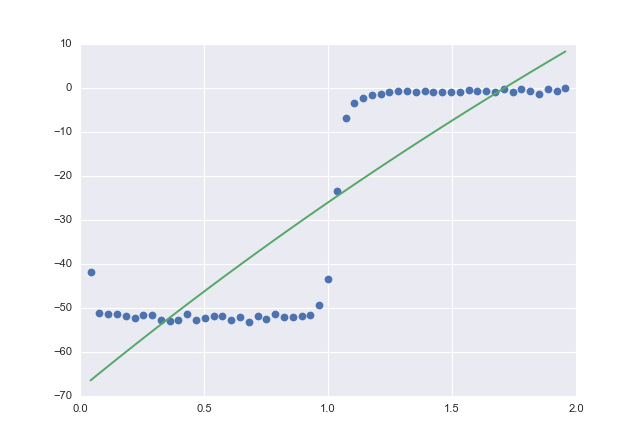

In [46]:
draw_interactive(f.plot())

In [20]:
trace0 = Scatter(x = mr, y = heats)
data = Data([trace0])

In [25]:
global_var

['blank', 'global_heat']

In [51]:
glob_exp, exp_w

({}, [])

In [26]:
f.param_guesses

({}, [{'dilution_heat': 0.0, 'dilution_intercept': 0.0}])

In [22]:
glob_test = glob_exp['global_heat']

In [23]:
glob_test.remove_exp()

In [128]:
global_param, local_param = f.fit_param
global_error, local_error = f.fit_error
n = 0

for param, error in zip(local_param, local_error):
    for p, e in zip(param, error):
        print("{},{}".format(p, n), ': ', param[p], error[e])
    n+=1

dH,0 :  2179.4 0.123439080702
fx_competent,0 :  1.01650347751 0.335816775955
dilution_intercept,0 :  7.67414710493 1.75280011595
K,0 :  31486172.0624 4.36286960563e-05
dilution_heat,0 :  -62629.3234509 0.00587066072782


In [129]:
global_param

{}

In [143]:
global_param, local_param = f.param_names
global_guesses, local_guesses = f.param_guesses
global_ranges, local_ranges = f.param_ranges
global_fixed, local_fixed = f.fixed_param 

In [78]:
exp = f.experiments[0]

In [80]:
f.param_bounds

({},
 [{'K': (-inf, inf),
   'dH': (-10000.0, 500.0),
   'dilution_heat': (-inf, inf),
   'dilution_intercept': (-inf, inf),
   'fx_competent': (-inf, inf)}])

In [77]:
exp_2 = exp_w[0][0]

In [60]:
exp_sliders = exp_2.gen_sliders()

In [61]:
exp_sliders

In [18]:
for s in exp_sliders:
    s.build_sliders()

TypeError: 'tuple' object is not callable

In [97]:
f.param_ranges

({'F': [-10000.0, 10000.0]},
 [{'K': [1.0, 100000000.0],
   'dilution_heat': [-10000.0, 10000.0],
   'dilution_intercept': [-10000.0, 10000.0],
   'fx_competent': [0.0, 2.0]},
  {'dilution_heat': [-10000.0, 10000.0],
   'dilution_intercept': [-10000.0, 10000.0]}])

In [ ]:
path = "t"

In [273]:
test_text = widgets.Text()
display(test_text)

def text_fire(sender):
    print(test_text.value)
    test_text.disabled = True
    
test_text.on_submit(text_fire)

how are you doing???


In [264]:
test_text.disabled = True

In [56]:
file_dropdown.options = file_dict

In [51]:
exp_path = widgets.Text(description = "Folder Path: ")
file_dropdown = widgets.Dropdown()
    
def pop_files(file_list):
    path_loc = exp_path.value
    path_name = "{}/**/*.DH".format(path_loc)
    
    file_list = glob.glob(path_name)
    file_dropdown.options = file_list
    
#file_inter = widgets.interactive(pop_files, file_list = file_dropdown)

In [277]:
file_dropdown.disabled = True

In [276]:
file_dropdown

In [124]:
file_list = glob.glob("./**/*.DH")
file_dict = {fname.split('/')[-1]: fname for fname in file_list}

In [125]:
file_dict

{'blank.DH': './test-data/blank.DH',
 'hA5A5conTESCaTCEP.DH': './test-data/hA5A5conTESCaTCEP.DH',
 'hA5NCX1TESCaTCEP.DH': './test-data/hA5NCX1TESCaTCEP.DH',
 'real-blank-match.DH': './test-data/real-blank-match.DH'}

In [463]:
class Sliders():
    def __init__(self, exp, fitter, gui, param_name, global_vars, global_exp):
        """
        """
        self._var_opt = {'link': ['blank'], 'unlink': ['unlink']}
        
        self._loc_link = widgets.Dropdown(value = self._var_opt['unlink'], options = self._var_opt)
        self._glob_link = widgets.Dropdown(value = self._loc_link.value[0], options = self._loc_link.value)
        self._fixed_check = widgets.Checkbox(value = False)
        self._slider = widgets.FloatSlider()
        self._fixed_int = widgets.FloatText(display = 'none')
        self._s_min = widgets.FloatText()
        self._s_max = widgets.FloatText()
        
        self._exp = exp
        self._fitter = fitter
        self._gui = gui
        self._param_name = param_name
        self._global_vars = global_vars
        self._global_exp = global_exp
        
        self._s_min.layout.width = '50px'
        self._s_max.layout.width = '50px'
        self._fixed_int.layout.width = '50px'
        self._fixed_int.layout.display = 'none'
    
    def logic(self):
    
        self._fixed_check.observe(self.check_change, 'value')
        self._loc_link.observe(self.link_change, 'value')
        self._s_min.observe(self.min_change, 'value')
        self._s_max.observe(self.max_change, 'value')
        self._slider.observe(self.param_change, 'value')

    #bound not range, but update range
    def min_change(self, min_val):

        self._slider.min = min_val['new']
        self.update_bounds(self._slider.min, self._slider.max)

    def max_change(self, max_val):

        self._slider.max = max_val['new']
        self.update_bounds(self._slider.min, self._slider.max)
        
    def update_bounds(self, s_min, s_max):
        
        bounds = [s_min, s_max]
        self._fitter.update_bounds(self._param_name, bounds, self._exp)
        
        # check if bounds are smaller than range, then update.
        curr_range = self._exp.model.param_guess_ranges[self._param_name]
        curr_bounds = self._exp.model.bounds[self._param_name]
        
        if curr_range[0] < curr_bounds[0] or curr_range[1] > curr_bounds[1]:
            self._fitter.update_range(self._param_name, bounds, self._exp)

    def check_change(self, val):

        if val['new']:
            self._slider.layout.display = 'none'
            self._fixed_int.layout.display = ''
            self._fitter.update_fixed(self._param_name, self._fixed_int.value, self._exp)
        elif val['new'] == False and self._loc_link.value[0] == 'link':
            self._slider.layout.display = 'none'
            self._fixed_int.layout.display = 'none'
        elif val['new'] == False and self._loc_link.value[0] == 'unlink': 
            self._slider.layout.display = ''
            self._fixed_int.layout.display = 'none'


    def link_change(self, select):

        if select['new'][0] == 'unlink' and self._fixed_check.value == False:
            self._slider.layout.display = ''
            self._fixed_int.layout.display = 'none'
        elif select['new'][0] == 'unlink' and self._fixed_check.value:
            self._slider.layout.display = 'none'
            self._fixed_int.layout.display = ''
        else:
            self._slider.layout.display = 'none'
            self._fixed_int.layout.display = 'none'

    def create_global(self, glob_var):

        if glob_var != 'unlink' and glob_var != 'blank':
            try:
                self._fitter.link_to_global(self._exp, self._param_name, glob_var)
                new_global = GlobalExp(self._gui, self._global_exp, self._fitter, glob_var)
                self._global_exp[glob_var] = new_global
            except:
                pass

    def create_local(self, loc_var):

        self._var_opt['link'] = self._global_vars
        self._loc_link.options = self._var_opt
        
        if loc_var[0] == 'unlink':
            try:
                self._fitter.unlink_from_global(self._exp, self._param_name)
            except: 
                pass
        else:
             self._glob_link.options = loc_var
                
    def param_change(self, param_val):
        
        guess = param_val['new']
        
        self._fitter.update_guess(self._param_name, guess, self._exp)
    
    def build_sliders(self):
        """
        build sliders!
        """
        
        self.logic()
        
        exp_range = self._exp.model.param_guess_ranges[self._param_name]
        self._slider.min = exp_range[0]
        self._slider.max = exp_range[1]
        
        bounds_label = widgets.Label(value = "bounds: ")
        name_label = widgets.Label(value = "{}: ".format(self._param_name))
        loc_inter = widgets.interactive(self.create_local, loc_var = self._loc_link)
        #loc_inter.layout.width = '200px'
        glob_inter = widgets.interactive(self.create_global, glob_var =  self._glob_link)
        #glob_inter.layout.width = '200px'

        min_max = widgets.HBox(children = [bounds_label, self._s_min, self._s_max])
        
        main = widgets.HBox(children = [self._fixed_check, self._slider, loc_inter, glob_inter, self._fixed_int, min_max])
        
        all_widgets = widgets.VBox(children = [name_label, main])
        all_widgets.layout.width = '80%'

        return all_widgets

In [475]:
glob_list = {}

In [476]:
exp = f.experiments[0]

In [485]:
slider = Sliders(exp, f, gui, 'dH', global_var, glob_exp)
dilution = Sliders(exp, f, gui, 'dilution_heat', global_var, glob_exp)

In [486]:
f.fit_param

({},
 [{'K': 1.0,
   'dH': -4000.0,
   'dilution_heat': 0.0,
   'dilution_intercept': 0.0,
   'fx_competent': 1.0}])

In [487]:
box = slider.build_sliders()
dilution_box = dilution.build_sliders()

In [53]:
def update_plot(children):
    
    if children['new'] != children['old']:
        f.fit()
        f.plot()
        
    print(children)

In [54]:
box.observe(update_plot, 'children')

In [259]:
box.layout.visibility = ''

In [488]:
box

In [489]:
dilution_box

In [490]:
glob_exp

{'S': <__main__.GlobalExp at 0x118046080>}

/Users/hrnmy/Documents/Harms/pytc/pytc/experiments.py:88: FutureWarning:

comparison to `None` will result in an elementwise object comparison in the future.

/Users/hrnmy/Documents/Harms/pytc/pytc/fitting.py:286: FutureWarning:

comparison to `None` will result in an elementwise object comparison in the future.

/Users/hrnmy/Documents/Harms/pytc/pytc/fitting.py:301: FutureWarning:

comparison to `None` will result in an elementwise object comparison in the future.



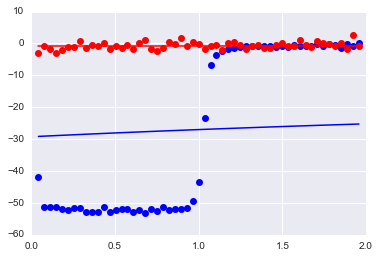

In [319]:
f.fit()
f.plot()

In [70]:
f.experiments[1].experiment_id

'dWnwqHQhTavPRcurrbda'

In [21]:
box.__dict__

{'_cross_validation_lock': False,
 '_model_id': '5a93da7299104cc68cb299e50de80750',
 '_trait_notifiers': {'background_color': {'change': [<function ipywidgets.widgets.domwidget.DOMWidget._deprecate_traits.<locals>.traitWarn>]},
  'color': {'change': [<function ipywidgets.widgets.domwidget.DOMWidget._deprecate_traits.<locals>.traitWarn>]},
  'comm': {'change': [<traitlets.traitlets.ObserveHandler at 0x1038ff550>]},
  'config': {'change': [<traitlets.traitlets.ObserveHandler at 0x1026668d0>]},
  'font_family': {'change': [<function ipywidgets.widgets.domwidget.DOMWidget._deprecate_traits.<locals>.traitWarn>]},
  'font_size': {'change': [<function ipywidgets.widgets.domwidget.DOMWidget._deprecate_traits.<locals>.traitWarn>]},
  'font_style': {'change': [<function ipywidgets.widgets.domwidget.DOMWidget._deprecate_traits.<locals>.traitWarn>]},
  'font_weight': {'change': [<function ipywidgets.widgets.domwidget.DOMWidget._deprecate_traits.<locals>.traitWarn>]},
  'value': {'change': [<functi

In [63]:
exp.model.param_guess_ranges['dH']

[-10000.0, 10000.0]

In [60]:
bounds = [3000, 100000]

In [63]:
f.update_bounds('dH', [-10000, 600], exp)

TypeError: 'dict' object is not callable

In [52]:
f.experiments

In [59]:
parameters = exp.param_values

In [60]:
parameters

{'K': 1000000.0,
 'dH': 10000.0,
 'dilution_heat': 0.0,
 'dilution_intercept': 0.0,
 'fx_competent': 1.0}

In [34]:
slider = Sliders(exp, f)
opt = slider.link(global_var)

In [35]:
def opt_one(glob_var):
    
    print(glob_var)

def opt_two(loc_var):
    
    drop_2.options = loc_var

In [36]:
drop_1 = widgets.Dropdown(options = opt)
val = drop_1.value
drop_2 = widgets.Dropdown(options = val)

i = widgets.interactive(opt_two, loc_var = drop_1)
j = widgets.interactive(opt_one, glob_var = drop_2)

In [98]:
dropdown = widgets.Dropdown(value = opt['unlink'], options = opt)
checkbox = widgets.Checkbox(value = False)
slider_w = widgets.FloatSlider()
float_text = widgets.FloatText()
float_min = widgets.FloatText()
float_max = widgets.FloatText()
float_min.layout.width = '100px'
float_max.layout.width = '100px'
float_text.layout.width = '50px'
float_text.layout.display = 'none'

glob_list = dropdown.value
glob_dropdown = widgets.Dropdown(options = glob_list)

In [110]:
def glob_change(glob_var):
    
    new_var = glob_var['new']
    
    if new_var and new_var not in global_var:
        global_var.append(new_var)
        opt_update = slider.link(global_var)
        dropdown.options = opt_update
        #global_field.value = ''
    else:
        pass
    
def glob_interact(glob_var):
    
    if glob_var and glob_var not in global_var:
        global_var.append(glob_var)
        opt_update = slider.link(global_var)
        dropdown.options = opt_update
        #global_field.value = ''
    else:
        pass
    
#bound not range, but update range
def min_change(min_val):

    slider_w.min = min_val['new']
    
def max_change(max_val):

    slider_w.max = max_val['new']

    
def check_change(val):
    
    if val['new']:
        slider_w.layout.display = 'none'
        float_text.layout.display = ''
    elif val['new'] == False and dropdown.value[0] == 'link':
        slider_w.layout.display = 'none'
        float_text.layout.display = 'none'
    elif val['new'] == False and dropdown.value[0] == 'unlink': 
        slider_w.layout.display = ''
        float_text.layout.display = 'none'
        #clear_output()
        
    #fixed and update fixed
        
def link_change(select):
    
    if select['new'][0] == 'unlink' and checkbox.value == False:
        slider_w.layout.display = ''
        float_text.layout.display = 'none'
    elif select['new'][0] == 'unlink' and checkbox.value:
        slider_w.layout.display = 'none'
        float_text.layout.display = ''
    elif select['new'][0] == 'link':
        slider_w.layout.display = 'none'
        float_text.layout.display = 'none'
    else: 
        clear_output()
        print(select['new'])
        
def opt_one(glob_var):
    
    # link variables here.
    
    pass

def opt_two(loc_var):
    
    opt_update = slider.link(global_var)
    dropdown.options = opt_update
    if loc_var[0] == 'unlink' or loc_var[0] == 'link':
        glob_dropdown.options = []
    else:
        glob_dropdown.options = loc_var
        

checkbox.observe(check_change, 'value')
dropdown.observe(link_change, 'value')
global_field.observe(glob_change, 'value')
float_min.observe(min_change, 'value')
float_max.observe(max_change, 'value')

In [88]:
widgets.interactive(glob_interact, glob_var = global_field)

In [111]:
label = widgets.Label(value = "bounds: ")
loc_inter = widgets.interactive(opt_two, loc_var = dropdown)
glob_inter = widgets.interactive(opt_one, glob_var = glob_dropdown)

box = widgets.HBox(children = [checkbox, slider_w, loc_inter, glob_inter, float_text])
box.layout.width = '90%'

min_max = widgets.HBox(children = [label, float_min, float_max])

display(min_max, box)

link


In [105]:
opt

{'dilution_heat': ['J', 'L', 'V', 'M', 'Z'],
 'dilution_intercept': ['J', 'L', 'V', 'M', 'Z'],
 'link': ['link'],
 'unlink': ['unlink']}

In [80]:
display(i, j)

M


In [47]:
slider.link()

{'K': None,
 'dH': None,
 'dilution_heat': None,
 'dilution_intercept': None,
 'fx_competent': None}

In [162]:
slider.layout.display = ''

In [161]:
slider.layout.visibility = 'visible'

In [27]:
s_test = sliders.gen_sliders()

In [28]:
s_test

{'fixed': <ipywidgets.widgets.widget_bool.Checkbox at 0x10af42710>,
 'int': <ipywidgets.widgets.widget_float.FloatText at 0x110f249e8>,
 'link': <ipywidgets.widgets.widget_selection.Dropdown at 0x10af427b8>}

In [57]:
blurp = widgets.interactive(logic, **s_test)

In [65]:
blurp.layout.flex_flow = 'row'
blurp.layout.flex = '1 1 1'

In [69]:
blurp.layout.width = '20%'

In [74]:
blurp.visible = True

In [104]:
blurp

In [138]:
#slider_b = widgets.Box(children = s_test.values())

In [54]:
update = widgets.Button(description = 'Update')
update.on_click(update_s)

In [55]:
display(update)

False


In [56]:
display?

In [67]:
update.close()

In [57]:
X = display(update)

In [59]:
update.open()

In [60]:
display(update)